In [1]:
import qgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
import h5py

### hapROH imports
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")  # hack to get development package first in path
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/hapBLOCK/IO/")  # hack to get development package first in path
from h5_load import get_coverage,get_genos_pairs,get_idx_iid,get_markers_good

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")


sys.path.insert(0, path)

compute-e-16-233.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 28


In [80]:
def island_cumsum_vectorized(a):
    a_ext = np.concatenate(( [0], a, [0] ))
    idx = np.flatnonzero(a_ext[1:] != a_ext[:-1])
    a_ext[1:][idx[1::2]] = idx[::2] - idx[1::2]
    return a_ext.cumsum()[1:-1]

def max_suffix_string(g1, g2):
    """Return the length of the maximal phased suffix genotype match.
    g1, g2: phased genotypes in format [l,2]
    Return [l] integer array"""
    suffix_strings = np.array([island_cumsum_vectorized(g1[:,i] == g2[:,j]) 
                               for i in range(2) for j in range(2)])
    max_suffix = np.max(suffix_strings, axis=0)
    return max_suffix

def plot_string_match(m, max_str, figsize=(12,4), s=12, ylim=[0,100], title="", c="darkviolet"):
    """Plot length of longest matching strings"""
    plt.figure(figsize=figsize)
    ax=plt.gca()
    ax.scatter(m, max_str, s=s, c=c)
    ax.set_ylim(ylim)
    ax.set_ylabel("Longest String Match across 4 haplotypes")
    ax.set_xlabel("centimorgan")
    ax.set_title(title)
    plt.show()

In [2]:
f = h5py.File("./data/hdf5/1240k_v43/ch9.h5", "r") # Load for Sanity Check. See below!

In [3]:
j1 = get_idx_iid(f, "COR001")
print(get_coverage(f, j1))
j2 = get_idx_iid(f, "COR002")
print(get_coverage(f, j2))

0.8464538858365138
1.1300381663381285


Filtering to 0.95 GP variants: 0.929x
Filtering to 0.95 GP variants: 0.954x
Filtering to common GP variants: 0.900x


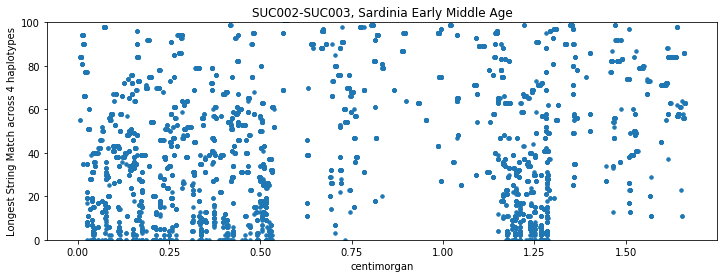

CPU times: user 743 ms, sys: 88 ms, total: 831 ms
Wall time: 811 ms


In [67]:
%%time
g1, g2, m = get_genos_pairs(f, sample1="COR001", sample2="COR002", 
                            cutoff=0.95, output=True, phased=True)

max_suffix = max_suffix_string(g1,g2)
max_prefix = max_suffix_string(g1[::-1],g2[::-1])[::-1]
max_str = max_suffix+max_prefix

plot_string_match(m, max_str, title="SUC002-SUC003, Sardinia Early Middle Age")

### Punier

Filtering to 0.95 GP variants: 0.817x
Filtering to 0.95 GP variants: 0.804x
Filtering to common GP variants: 0.703x


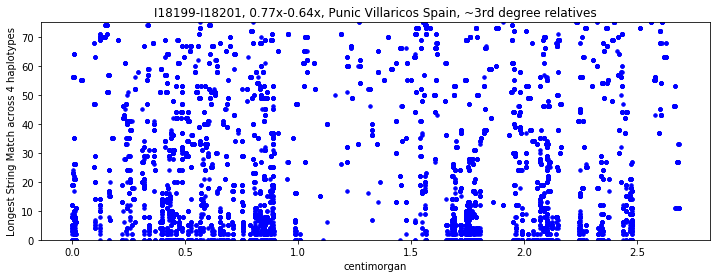

CPU times: user 987 ms, sys: 122 ms, total: 1.11 s
Wall time: 1.08 s


In [93]:
%%time
f = h5py.File("./data/hdf5/1240k_v43/ch2.h5", "r") # Load for Sanity Check. See below!
g1, g2, m = get_genos_pairs(f, sample1="I18199", sample2="I18201", 
                            cutoff=0.95, output=True, phased=True)

max_suffix = max_suffix_string(g1,g2)
max_prefix = max_suffix_string(g1[::-1],g2[::-1])[::-1]
max_str = max_suffix+max_prefix

plot_string_match(m, max_str, title="I18199-I18201, 0.77x-0.64x, Punic Villaricos Spain, ~3rd degree relatives", ylim=[0,75], c="blue")
f.close()